## Comparing Lomap and OpenFE usage

This notebook demonstrates how to recreate the behaviour of Lomap2 using the OpenFE package.

Firstly Lomap, which just takes a path to where the molecules are held:

In [49]:
import lomap

lomap_mols = lomap.DBMolecules('./molecules', output=True, radial=True)

strict, loose = lomap_mols.build_matrices()

strict = strict.to_numpy_2D_array()

print(strict)

[[0.         0.20189652 0.90483742 0.74081822 0.81873075 0.77880078
  0.52204578 0.22313016 0.54881164 0.54881164]
 [0.20189652 0.         0.22313016 0.27253179 0.24659696 0.23457029
  0.67032005 0.27253179 0.67032005 0.67032005]
 [0.90483742 0.22313016 0.         0.81873075 0.90483742 0.86070798
  0.4965853  0.24659696 0.60653066 0.4965853 ]
 [0.74081822 0.27253179 0.81873075 0.         0.74081822 0.70468809
  0.27253179 0.20189652 0.4965853  0.27253179]
 [0.81873075 0.24659696 0.90483742 0.74081822 0.         0.95122942
  0.30119421 0.27253179 0.67032005 0.30119421]
 [0.77880078 0.23457029 0.86070798 0.70468809 0.95122942 0.
  0.52204578 0.25924026 0.63762815 0.52204578]
 [0.52204578 0.67032005 0.4965853  0.27253179 0.30119421 0.52204578
  0.         0.33287108 0.81873075 0.95122942]
 [0.22313016 0.27253179 0.24659696 0.20189652 0.27253179 0.25924026
  0.33287108 0.         0.40656966 0.33287108]
 [0.54881164 0.67032005 0.60653066 0.4965853  0.67032005 0.63762815
  0.81873075 0.40656

### OpenFE version

Now moving onto recreating this in OpenFE.
This will involve a few more steps than with Lomap, as various tasks (such as reading files) have been made explicit.
This is slightly tedious, but allows the process to be much more powerful as with each step explicity, these components can be switched out and a wide variety of different techniques combined.

In [60]:
import openfe
import os
from rdkit import Chem
import numpy as np
import itertools

# load molecules in the same order as Lomap did
fnames = [os.path.join('molecules', lomap_mols[i].getName())
          for i in range(10)]

smallmols = []
for fname in fnames:
    if 'mol2' in fname:
        m = Chem.MolFromMol2File(fname, removeHs=False)
    else:
        m = Chem.MolFromMolFile(fname, removeHs=False)
    # OpenFE lightly wraps rdkit molecules
    # to make them hashable and immutable
    smallmols.append(openfe.setup.SmallMoleculeComponent.from_rdkit(m))

### Simple Mapper usage

To create the scoring matrix in OpenFE, first the `mapper` and `scorer` objects must be created.
These are separate objects representing the separation in responsibility between proposing and evaluating an atom mapping.
The `LomapAtomMapper` class and `default_lomap_score` function implement the default Lomap atom mapper and scoring function respectively,
and so are used here for the back to back validation.


Score is 0.7981034820053445


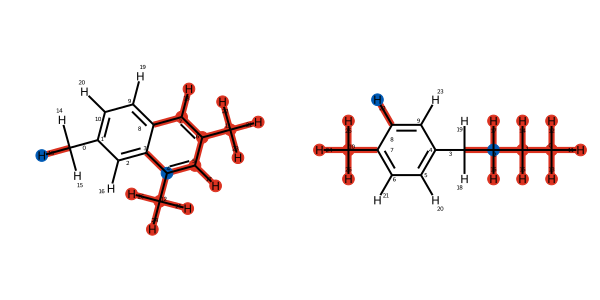

In [58]:
# LomapAtomMapper wraps the lomap.mcs.MCS object
mapper = openfe.setup.LomapAtomMapper()
scorer = openfe.setup.lomap_scorers.default_lomap_score

molA = smallmols[0]
molB = smallmols[1]

# mappers can return an *iterable* of mappings,
# for our case just grab the first with `next()`
mapping = next(mapper.suggest_mappings(molA, molB))

print(f"Score is {scorer(mapping)}")

mapping

### Creating the score matrix

To fill the scores matrix, all possible combinations of molecules are iterated over (here using `itertools.combinations`) 

In [55]:
mapper = openfe.setup.LomapAtomMapper()
scorer = openfe.setup.lomap_scorers.default_lomap_score

scores = np.zeros((10, 10))

for i, j in itertools.combinations(range(len(smallmols)), 2):
    molA = smallmols[i]
    molB = smallmols[j]
    
    mapping = next(mapper.suggest_mappings(molA, molB))
    
    score = scorer(mapping)
    
    scores[i, j] = score
    scores[j, i] = score
# set diagonal for easier comparison
for i in range(10):
    scores[i, i] = 1.0

In OpenFE higher scores are more dissimilar and unfavourable, in contrast to Lomap where low scores are "worse".
The default Lomap scorer in OpenFE is implemented as `1 - Lomap`.
We can then verify that the scoring matrix we have produced is identical to that of Lomap's.

In [56]:
1 - scores

array([[0.        , 0.20189652, 0.90483742, 0.74081822, 0.81873075,
        0.77880078, 0.52204578, 0.22313016, 0.54881164, 0.54881164],
       [0.20189652, 0.        , 0.22313016, 0.27253179, 0.24659696,
        0.23457029, 0.67032005, 0.27253179, 0.67032005, 0.67032005],
       [0.90483742, 0.22313016, 0.        , 0.81873075, 0.90483742,
        0.86070798, 0.4965853 , 0.24659696, 0.60653066, 0.4965853 ],
       [0.74081822, 0.27253179, 0.81873075, 0.        , 0.74081822,
        0.70468809, 0.27253179, 0.20189652, 0.4965853 , 0.27253179],
       [0.81873075, 0.24659696, 0.90483742, 0.74081822, 0.        ,
        0.95122942, 0.30119421, 0.27253179, 0.67032005, 0.30119421],
       [0.77880078, 0.23457029, 0.86070798, 0.70468809, 0.95122942,
        0.        , 0.52204578, 0.25924026, 0.63762815, 0.52204578],
       [0.52204578, 0.67032005, 0.4965853 , 0.27253179, 0.30119421,
        0.52204578, 0.        , 0.33287108, 0.81873075, 0.95122942],
       [0.22313016, 0.27253179, 0.2465969

In [57]:
np.allclose(strict - (1 - scores), 0)

True